# Computer Assignment 3

## Problem 1

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pywt
from collections import deque
from copy import deepcopy

In [11]:
pyramidTypes = ["Gaussian", "Laplacian"]

In [12]:
#Function to compute Gaussian Pyramid of given image
def gaussianPyramid(image, j_level):
  gaussian_pyramid_images = []
  for i in range(j_level):
    if i == 0:
      gaussian_pyramid_images.append(image)

    elif image.shape[0] > 1 and image.shape[1] > 1:
      image = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2), interpolation=cv2.INTER_LINEAR)
      gaussian_pyramid_images.append(image)

  return gaussian_pyramid_images



In [13]:
#Function to compute Laplacian Pyramid of given image
def laplacianPyramid(image, j_level):
  laplacian_pyramid_images = []
  for i in range(j_level):
    if i == j_level - 1:
      laplacian_pyramid_images.append(image)
    
    elif image.shape[0] > 1 and image.shape[1] > 1:
      image_d = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2), interpolation=cv2.INTER_LINEAR)
      image_u = cv2.resize(image_d, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
      l_image = image - image_u
      laplacian_pyramid_images.append(l_image)
      image = image_d

  return laplacian_pyramid_images

In [14]:
def getPyramid(image, pyramid_type, level):
  if pyramid_type == pyramidTypes[0]:
    pyramid = gaussianPyramid(image, level)

  elif pyramid_type == pyramidTypes[1]:
    pyramid = laplacianPyramid(image, level)

  return pyramid

In [15]:
def displayPyramid(image, pyramid_type, level):
  rows, cols = image.shape
  pyramid = getPyramid(image, pyramid_type, level)

  #Normalize the values in case of laplacian pyramid so that it can be displayed properly
  if pyramid_type == pyramidTypes[1]:
    for i in range(len(pyramid)):
      pyramid[i] = np.round((pyramid[i]-np.min(pyramid[i]))*255/(np.max(pyramid[i])-np.min(pyramid[i])))

  #To Display image in composite manner,
  composite_image = np.zeros((rows, cols+cols//2), dtype=np.float64)
  composite_image[:rows, :cols] = pyramid[0]

  i_row = 0
  for p in pyramid[1:]:
      n_rows, n_cols = p.shape
      composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
      i_row += n_rows

  plt.figure(figsize = (15,7))
  plt.imshow(composite_image, cmap='gray')
  plt.title(pyramid_type)

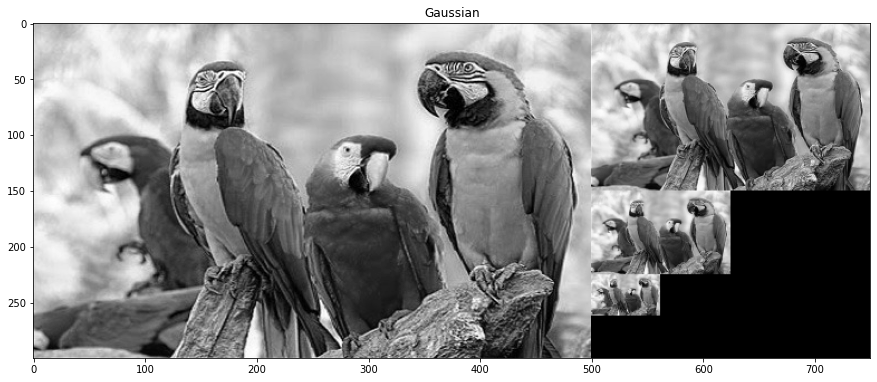

In [16]:
#Display Gaussian Pyramid upto J=3
img = cv2.imread("bird2.jpg", cv2.IMREAD_GRAYSCALE).astype(float)
displayPyramid(img, pyramidTypes[0], 4)

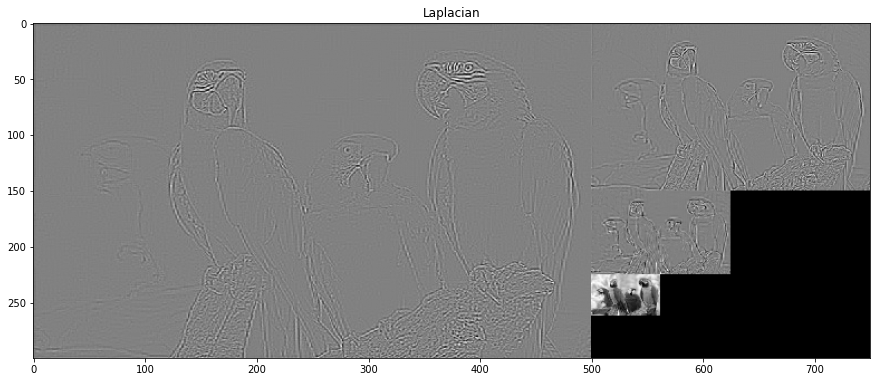

In [17]:
#Display Laplacian Pyramid upto J=3
img = cv2.imread("bird2.jpg", cv2.IMREAD_GRAYSCALE).astype(float)
displayPyramid(img, pyramidTypes[1], 4)

In [18]:
def reconstructLaplacian(l_pyramid):
  r_image = l_pyramid[0]
  for i in range(len(l_pyramid)-1):
    rev_i = len(l_pyramid) - i - 2
    if i == 0:
      r_image = l_pyramid[rev_i] + cv2.resize(l_pyramid[rev_i+1], (l_pyramid[rev_i].shape[1], l_pyramid[rev_i].shape[0]), interpolation = cv2.INTER_CUBIC)
    else:
      r_image = l_pyramid[rev_i] + cv2.resize(r_image, (l_pyramid[rev_i].shape[1], l_pyramid[rev_i].shape[0]), interpolation = cv2.INTER_CUBIC)

  return r_image

Text(0.5, 1.0, 'Reconstructed')

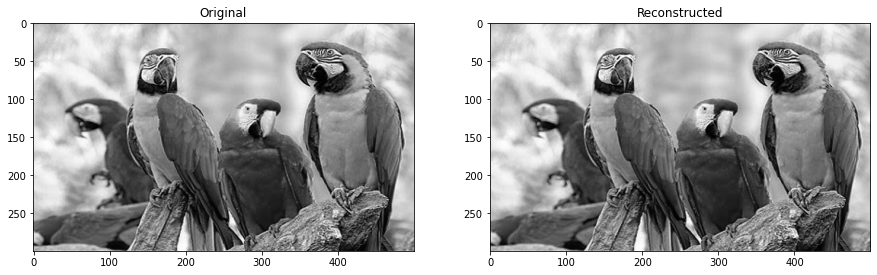

In [19]:
#Reconstruct Image from Laplacian Pyramid
img = cv2.imread("bird2.jpg", cv2.IMREAD_GRAYSCALE).astype(float)
l_pyramid = laplacianPyramid(img, 4)
reconstructed_image = reconstructLaplacian(l_pyramid)
plt.figure(figsize = (15,7))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed")

In [20]:
#Q: Step Size, 
def quantizePyramid(pyramid, Q):
  quantized_pyramid = deepcopy(pyramid)
  
  mean = []
  for i in range(len(pyramid)):
    if i < len(pyramid) - 1:
      mean.append(0)
    elif i == len(pyramid) - 1:
      mean.append(128)

  for i in range(len(pyramid)):
    quantized_pyramid[i] = Q*np.floor((pyramid[i]-mean[i])/Q + 0.5) + mean[i]

  return quantized_pyramid

In [21]:
def numOfNonZeroes(pyramid):
  val = 0
  for i in range(len(pyramid)):
    val += np.count_nonzero(pyramid[i])

  return val

<ipython-input-34-c66ad8018e8d>:13: RuntimeWarning: divide by zero encountered in double_scalars
  psnr.append(10*np.log10((255**2)/np.mean((reconstructed_image - img)**2)))


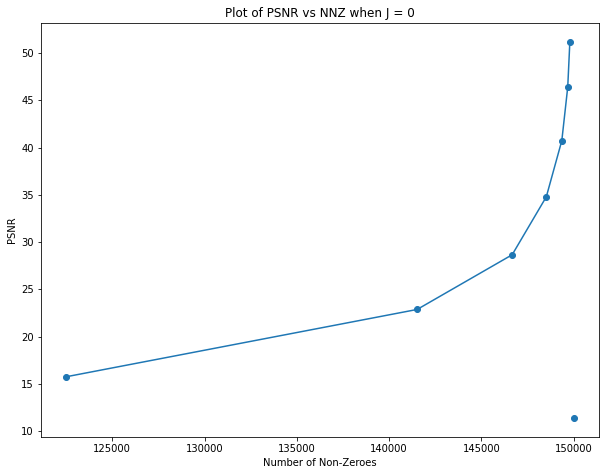

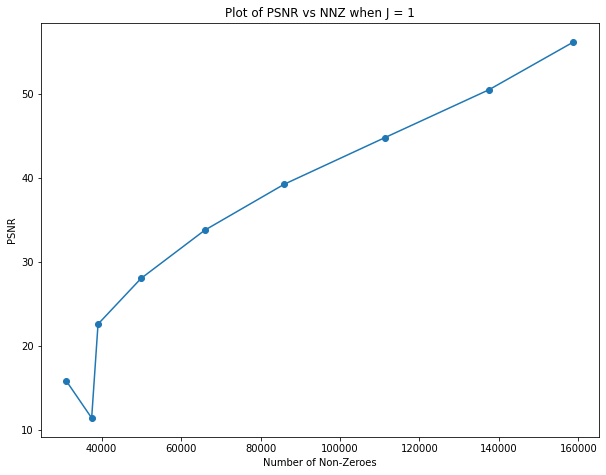

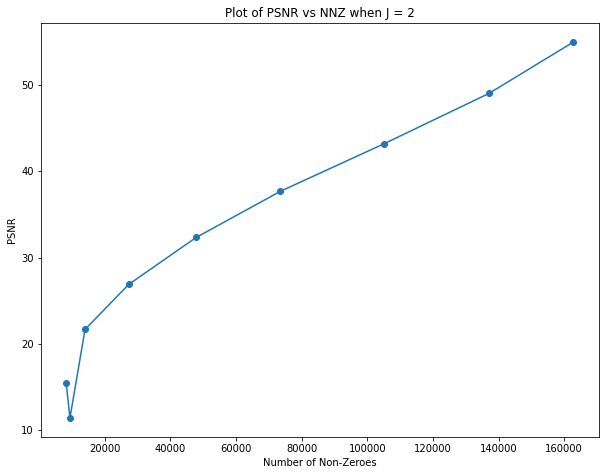

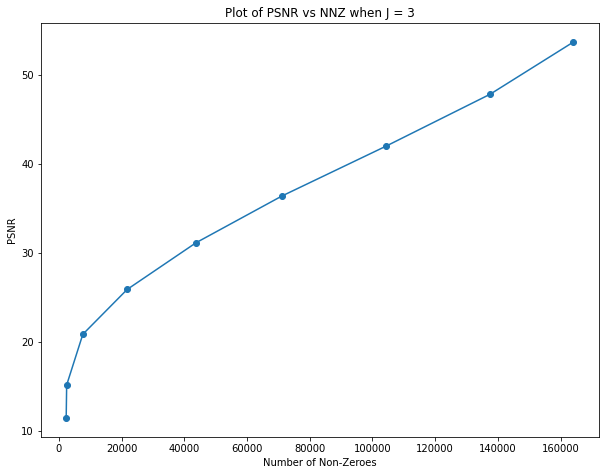

In [34]:
#Main Function 1 to plot PSNR vs NNZ graph
img = cv2.imread("bird2.jpg", cv2.IMREAD_GRAYSCALE).astype(float)

for j_level in range(1, 5):
  pyramid = laplacianPyramid(img, j_level)
  nnz = []
  psnr = []
  for i in range(9):
    Q = 2**i
    quantized_pyramid = quantizePyramid(pyramid, Q)
    reconstructed_image = reconstructLaplacian(quantized_pyramid)
    nnz.append(numOfNonZeroes(quantized_pyramid))
    psnr.append(10*np.log10((255**2)/np.mean((reconstructed_image - img)**2)))
  
  psnr_nnz = zip(nnz, psnr)
  sorted_psnr_nnz = sorted(psnr_nnz)
  nnz, psnr = zip(*sorted_psnr_nnz)

  plt.figure(figsize = (10,35))
  plt.subplot(4, 1, j_level)
  plt.plot(nnz, psnr, marker='o')
  plt.xlabel("Number of Non-Zeroes")
  plt.ylabel("PSNR")
  plt.title("Plot of PSNR vs NNZ when J = " + str(j_level-1))

## Answer 1. d
### We can observe that as depth of pyramid increases, with less number of non-zero values, high PSNR value can be acheived. Or we can say that representation efficiency increases with increasing depth.

### Yes this was expected as more number of levels means more details can be captured and hence more efficient representation.

## Answer 1. e
### Higher PSNR means better quality of image (very less noise). Hence, if there is large increase in PSNR value, image quality be different. Hence, we observe that for J=3, when quantization value was low i.e. 2 or 4, there was very less change in PSNR value and hence at that time it was un-noticeable.



## Problem 2

In [1]:
def wavelet_transform(image, level):
  haar_wavelet = 'db1'
  wavelets = deque()
  wavelets.append(image)

  for i in range(level):
    approx, (horiz, vert, diag) = pywt.dwt2(wavelets.popleft(), haar_wavelet, mode='symmetric')
    wavelets.appendleft((horiz, vert, diag))
    wavelets.appendleft(approx)
    
  return wavelets

In [2]:
def reconstruct_wavelet(wavelets):
  haar_wavelet = 'db1'
  length = len(wavelets)
  levels = length-1
  wavelets = deepcopy(wavelets)

  for i in range(levels):
    temp1 = wavelets.popleft()
    temp2 = wavelets.popleft()

    #To make dimensions of image recontructed at certain level and co-efficients of next level
    #Here, we ignore extra length created during image reconstruction by pywt.idwt2()
    if temp1.shape[0] != temp2[0].shape[0]:
            temp1 = temp1[0:-1,:]
    if temp1.shape[1] != temp2[0].shape[1]:
            temp1 = temp1[:,0:-1]

    temp_wavelet = (temp1, temp2)
    temp_image = pywt.idwt2(temp_wavelet, haar_wavelet, mode='symmetric')
    wavelets.appendleft(temp_image)

  return wavelets.popleft()

Text(0.5, 1.0, 'Reconstructed')

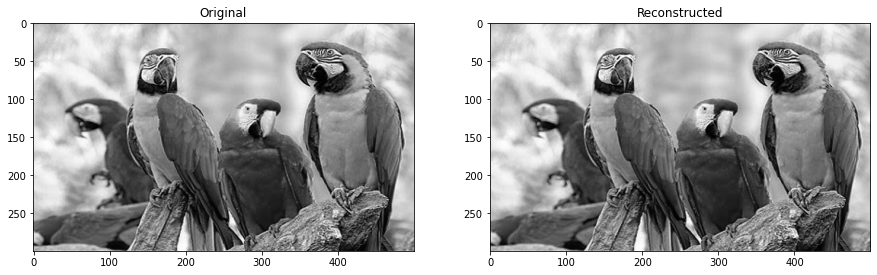

In [5]:
#Display Original and Reconstructed image to verify wavelets construction and reconstruction is working fine
original_image = cv2.imread("bird2.jpg", cv2.IMREAD_GRAYSCALE).astype(float)

wavelets = wavelet_transform(original_image, 3)
recontructed_image = reconstruct_wavelet(wavelets)

plt.figure(figsize = (15,7))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(recontructed_image, cmap='gray')
plt.title("Reconstructed")


In [6]:
#Q: Step Size,
def quantizeWavelets(wavelets, Q):
  quantized_wavelets = deepcopy(wavelets)

  for i in range(len(quantized_wavelets)):
    if i != 0:
      quantized_wavelets[i] = list(quantized_wavelets[i])
  
  mean = []
  for i in range(len(wavelets)):
    if i == 0:
      mean.append(128)
    else:
      mean.append(0)

  for i in range(len(wavelets)):
    if i == 0:
      quantized_wavelets[i] = Q*np.floor((wavelets[i]-mean[i])/Q + 0.5) + mean[i]
    else:
      for j in range(3):
        quantized_wavelets[i][j] = Q*np.floor((wavelets[i][j]-mean[i])/Q + 0.5) + mean[i]

  for i in range(len(quantized_wavelets)):
    if i != 0:
      quantized_wavelets[i] = tuple(quantized_wavelets[i])

  return quantized_wavelets

In [7]:
def numOfNonZeroesWavelets(wavelets):
  val = 0
  for i in range(len(wavelets)):
    if i == 0:
      val += np.count_nonzero(wavelets[i])
    else:
      for j in range(3):
        val += np.count_nonzero(wavelets[i][j])
  return val

<ipython-input-33-bf3dbedc0bed>:13: RuntimeWarning: divide by zero encountered in double_scalars
  psnr.append(10*math.log10((255**2)/np.mean((reconstructed_image - img)**2)))


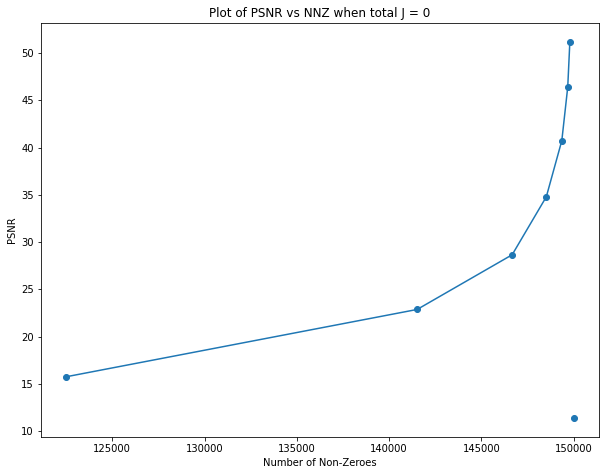

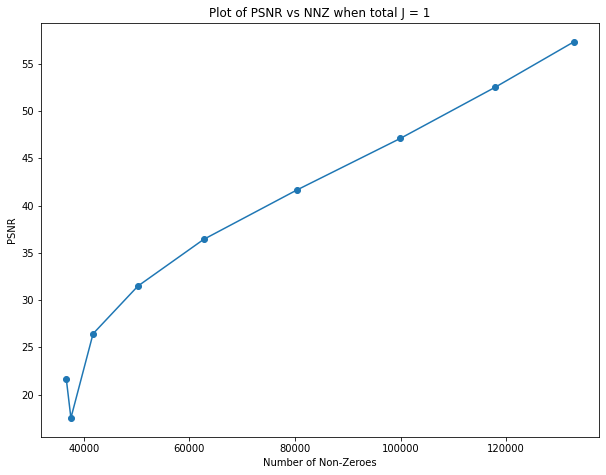

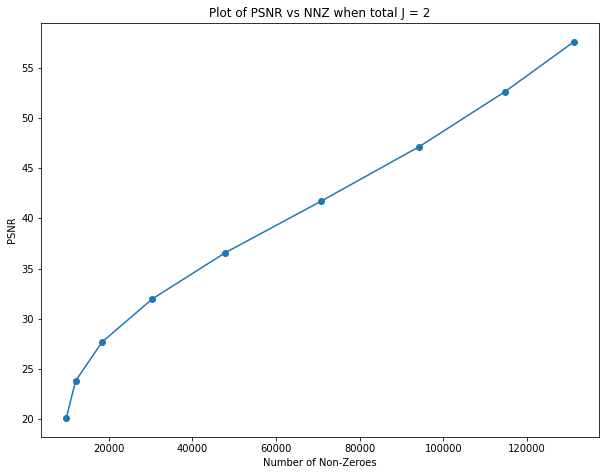

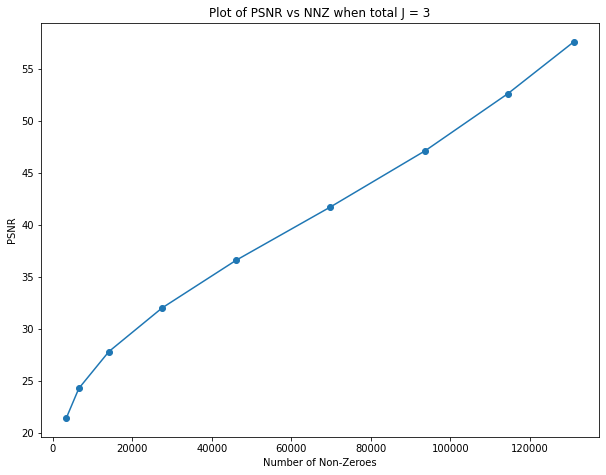

In [33]:
#Main Function 2
img = cv2.imread("bird2.jpg", cv2.IMREAD_GRAYSCALE).astype(float)

for j_level in range(0, 4):
  wavelets = wavelet_transform(img, j_level)
  nnz = []
  psnr = []
  for i in range(9):
    Q = 2**i
    quantized_wavelets = quantizeWavelets(wavelets, Q)
    reconstructed_image = reconstruct_wavelet(quantized_wavelets)
    nnz.append(numOfNonZeroesWavelets(quantized_wavelets))
    psnr.append(10*math.log10((255**2)/np.mean((reconstructed_image - img)**2)))

  psnr_nnz = zip(nnz, psnr)
  sorted_psnr_nnz = sorted(psnr_nnz)
  nnz, psnr = zip(*sorted_psnr_nnz)

  plt.figure(figsize = (10,35))
  plt.subplot(4, 1, j_level+1)
  plt.plot(nnz, psnr, marker='o')
  plt.xlabel("Number of Non-Zeroes")
  plt.ylabel("PSNR")
  plt.title("Plot of PSNR vs NNZ when total J = " + str(j_level))

## Answer 2. c

### If we compare plot of PSNR vs NNZ of laplacian pyramid and Wavelets, we can see that in case of wavelets, less number of non-zero values are required to acheive higher PSNR which means wavelets increase representation efficiency.